# Instalando dependências

In [ ]:
!pip install python-telegram-bot requests matplotlib

'''
python-telegram-bot: biblioteca para criação de bots escritos em python
para o Telegram telegram.

requests: biblioteca específica para fazer requisições
(pedidos de dados externos).

matplotlib: biblioteca com ênfase em dados (útil para criação de gráficos).
'''

# Criando variáveis

In [ ]:
primeira_dose = 177085
segunda_unica_dose = 8348
terceira_dose = 195209
total_hoje_doses = primeira_dose + segunda_unica_dose + terceira_dose

total_primeira_dose = 163738133
total_segunda_dose = 149173879
total_terceira_dose = 43455849
total_doses = total_primeira_dose + total_segunda_dose + total_terceira_dose

total_obitos_hoje = 0
total_obitos = 624129

atualizacao = ''

# Consumindo API

In [ ]:
import requests
import json

# API: forma de comunicações entre aplicações. Esses dados virão em formato json.
requisicao = requests.get("https://api.vacinacao-covid19.com/coronavirusbra1/tables/global.json?_=1638963356763")

if requisicao.status_code == 200:
  dados_texto = requisicao.text
  dados_estados = json.loads(dados_texto)
  atualizacao = dados_estados[25]['vaccinations']['last_update']

  for estado in dados_estados:
    total_primeira_dose += estado['vaccinations']['doses_1']
    total_segunda_dose += estado['vaccinations']['doses_2'] + estado['vaccinations']['doses_0']
    total_terceira_dose += estado['vaccinations']['doses_3']
    total_doses += estado['vaccinations']['total']

    if estado['deaths']['new'] == None:
      total_obitos_hoje += 0
    else:
      total_obitos_hoje += estado['deaths']['new']

    total_obitos += estado['deaths']['total']

# Formatação de dados

In [ ]:
# Criação de função para a formatação dos dados
def formata_numeros(n):
  n = f'{n:_.0f}'
  n = n.replace("_", ".")
  return n

# Atualização (por fatiamento de strings). String = texto.
dia = '26'
mes = '01'
ano = '2022'
atualizacao = dia + '/' + mes + '/' + ano

# Inclusão de pontos nos estritamente numéricos dados numéricos
primeira_dose = formata_numeros(primeira_dose)
segunda_unica_dose = formata_numeros(segunda_unica_dose)
terceira_dose = formata_numeros(terceira_dose)
total_hoje_doses = formata_numeros(total_hoje_doses)

total_primeira_dose = formata_numeros(total_primeira_dose)
total_segunda_dose = formata_numeros(total_segunda_dose)
total_terceira_dose = formata_numeros(total_terceira_dose)
total_doses = formata_numeros(total_doses)

total_obitos_hoje = formata_numeros(total_obitos_hoje)
total_obitos = formata_numeros(total_obitos)

# Criação de gráficos

## Gráfico de vacinação (pop. total)



In [ ]:
import matplotlib.pyplot as plt

# Criação de variáveis auxiliares
populacao_total = 213317639
populacao_totalmente_vacinada = int(total_segunda_dose.replace(".", ""))
porcentagem_vacinada = populacao_totalmente_vacinada/populacao_total * 100

# Gráfico de pizza da população vacinada x não vacinada.
# Criação de rótulos e porcentagens.
labels = "Pop. totalmente vacinada", "Pop. não vacinada"
sizes = [porcentagem_vacinada, 100 - porcentagem_vacinada]

# Criando a representação.
fig1, ax1 = plt.subplots()

# Criando o gráfico.
ax1.pie(sizes, labels = labels, autopct = "%1.1f%%",
        shadow = True, startangle = 0)

# Tornando-o circular.
ax1.axis("equal")

plt.savefig("vac_total.png")
grafico_total = "vac_total.png"

## Gráfico de vacinação (pop. vacinável)

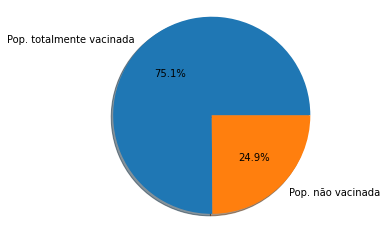

In [ ]:
import matplotlib.pyplot as plt

# Criação de variáveis auxiliares
populacao_vacinavel = 198614358
porcentagem_vacinavel = populacao_totalmente_vacinada/populacao_vacinavel * 100

# Gráfico de pizza da população vacinada x não vacinada.
# Criação de rótulos e porcentagens.
labels = "Pop. totalmente vacinada", "Pop. não vacinada"
sizes = [porcentagem_vacinavel, 100 - porcentagem_vacinavel]

# Criando a representação.
fig1, ax1 = plt.subplots()

# Criando o gráfico.
ax1.pie(sizes, labels = labels, autopct = "%1.1f%%",
        shadow = True, startangle = 0)

# Tornando-o circular.
ax1.axis("equal")

plt.savefig("vac_vacinavel.png")
grafico_vacinavel = "vac_vacinavel.png"

# Criação de manipulação de datas para a dose de reforço

In [ ]:
from datetime import date
from dateutil.relativedelta import relativedelta

def calcula_diferenca(data_segunda_dose):
  try:
    data_formatada = date(int(data_segunda_dose[-4:]), int(data_segunda_dose[3:5]), int(data_segunda_dose[0:2]))
    data_corrente = date.today()
    intervalo = relativedelta(data_corrente, data_formatada)
    if(intervalo.months >= 4):
      return True, 0
    else:
      return False, 4 - intervalo.months
  except ValueError:
    return False, -15

# Definição de comportamentos do bot

In [ ]:
import logging

from telegram import Update, ForceReply
from telegram.ext import Updater, CommandHandler, MessageHandler, Filters, CallbackContext

logging.basicConfig(
    format='%(asctime)s - %(name)s - %(levelname)s - %(message)s', level=logging.INFO
)

logger = logging.getLogger(__name__)

def fonte():
  return f"Fonte dos dados: https://coronavirusbra1.github.io/"

def start(update: Update, context: CallbackContext) -> None:
  update.message.reply_text("Use os comandos para receber as informações mais recentes da covid no país.\nCaso tenha dúvidas quanto ao funcionamento do bot, use /ajuda.")
  update.message.reply_text(fonte())

def vachoje(update: Update, context: CallbackContext) -> None:
  update.message.reply_text(f"1ª dose: {primeira_dose}\n2ª e única: {segunda_unica_dose}\n3ª dose: {terceira_dose}\nTotal de doses aplicadas hoje: {total_hoje_doses}\nÚltima atualização: {atualizacao}")
  update.message.reply_text(fonte())

def vactotal(update: Update, context: CallbackContext) -> None:
  update.message.reply_text(f"1ª dose: {total_primeira_dose}\n2ª e única: {total_segunda_dose}\n3ª dose: {total_terceira_dose}\nTotal de doses aplicadas: {total_doses}\nÚltima atualização: {atualizacao}")
  update.message.reply_text("Gráfico de vacinação em relação à população total:")
  update.message.reply_photo(photo = open(grafico_total, "rb"))
  update.message.reply_text("Gráfico de vacinação em relação à população vacinável:")
  update.message.reply_photo(photo = open(grafico_vacinavel, "rb"))
  update.message.reply_text(fonte())

def obithoje(update: Update, context: CallbackContext) -> None:
  update.message.reply_text(f"Número de óbitos registrados hoje: {total_obitos_hoje}\nÚltima atualização: {atualizacao}")
  update.message.reply_text(fonte())

def obittotal(update: Update, context: CallbackContext) -> None:
  update.message.reply_text(f"Total de óbitos: {total_obitos}\nÚltima atualização: {atualizacao}")
  update.message.reply_text(fonte())

def dosereforco(update: Update, context: CallbackContext) -> None:
  viabilidade, periodo_restante = calcula_diferenca(context.args[0])
  if(viabilidade):
    update.message.reply_text("Você já pode tomar sua dose de reforço! Procure o posto de vacinação mais próximo.")
  else:
    if periodo_restante == -15:
      update.message.reply_text("Desculpe! Você deve ter digitado uma data inválida. Tente botá-la no formato DD/MM/AAAA.\nExemplo: /dosereforco 01/01/2021")
    elif periodo_restante == 1:
      update.message.reply_text(f"Você ainda não pode tomar a dose de reforço. Espere mais {periodo_restante} mês.")
    else:
      update.message.reply_text(f"Você ainda não pode tomar a dose de reforço. Espere mais {periodo_restante} meses.")
  
  update.message.reply_text("Fonte para comparação: https://www.gov.br/saude/pt-br/assuntos/noticias/2021-1/dezembro/ministerio-da-saude-antecipa-de-cinco-para-quatro-meses-a-aplicacao-da-dose-de-reforco")

def ajuda(update: Update, context: CallbackContext) -> None:
  update.message.reply_text("Utilize os seguintes comandos:\n/vachoje (Saber dados da vacinação de hoje)\n/obithoje (Saber dados de óbitos de hoje)\n/vactotal (Saber dados sobre o total de pessoas vacinadas)\n/obittotal (Saber dados sobre o total de óbitos pela doença\n/dosereforco (Saber se você já pode tomar a dose de reforço. Use o comando passando a data de sua segunda dose no formato DD/MM/AAAA))")

def main():
  #Iniciando bot
  updater = Updater("token")
  dispatcher = updater.dispatcher

  dispatcher.add_handler(CommandHandler("start", start))
  dispatcher.add_handler(CommandHandler("vachoje", vachoje))
  dispatcher.add_handler(CommandHandler("obithoje", obithoje))
  dispatcher.add_handler(CommandHandler("vactotal", vactotal))
  dispatcher.add_handler(CommandHandler("obittotal", obittotal))
  dispatcher.add_handler(CommandHandler("dosereforco", dosereforco))
  dispatcher.add_handler(CommandHandler("ajuda", ajuda))

  updater.start_polling()

  updater.idle()

if __name__ == '__main__':
  main()